# GraphFrames

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from graphframes import *
import networkx as nx

In [2]:
# Create context
spark = SparkSession.builder.appName("asheesh").getOrCreate()
sqlContext = SQLContext(spark.sparkContext)

22/04/05 08:55:24 WARN Utils: Your hostname, a-Lenovo-Legion-Y530-15ICH resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface wlp7s0)
22/04/05 08:55:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/05 08:55:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Create a Vertex DataFrame with unique ID column "id"
v = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])
v.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
+---+-------+---+



In [4]:
# Create an Edge DataFrame with "src" and "dst" columns
e = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])
e.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
+---+---+------------+



In [5]:
# Create a GraphFrame
g = GraphFrame(v, e)

In [6]:
def draw_graph(graphframe,sample_count=100):
    edge_list=[(row['src'],row['dst'],1) for row in graphframe.edges.take(sample_count)]
    node_list=[(row['id']) for row in graphframe.vertices.take(sample_count)]
    import networkx as nx
    G=nx.Graph()
    G.add_nodes_from(node_list)
    G.add_weighted_edges_from(edge_list)
    nx.draw_networkx(G)
    

    

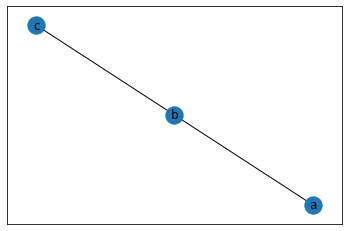

In [7]:
draw_graph(g)

In [8]:
# dir(g)
# g.edges.take(100)
# g.vertices
    

In [9]:
# Query: Get in-degree of each vertex.
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  c|       1|
|  b|       2|
+---+--------+



In [10]:
# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

2

In [11]:
# Find the youngest user's age in the graph.
g.vertices.groupBy().min("age").show()

+--------+
|min(age)|
+--------+
|      30|
+--------+



# Motif finding

Motif finding refers to searching for structural patterns in a graph.

In [12]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

In [13]:
# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|    [b, Bob, 36]|[b, c, follow]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, b, follow]|
+----------------+--------------+----------------+--------------+



In [14]:
# More complex queries can be expressed by applying filters.
motifs.filter("b.age > 30").show()

+----------------+--------------+------------+--------------+
|               a|             e|           b|            e2|
+----------------+--------------+------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|[b, Bob, 36]|[b, c, follow]|
+----------------+--------------+------------+--------------+



# Subgraphs

In [15]:
# Select subgraph of users older than 30, and relationships of type "friend".
# Drop isolated vertices (users) which are not contained in any edges (relationships).
g1 = g.filterVertices("age > 30").filterEdges("relationship = 'friend'").dropIsolatedVertices()
g1.vertices.show()

+---+-----+---+
| id| name|age|
+---+-----+---+
|  b|  Bob| 36|
|  a|Alice| 34|
+---+-----+---+



# Graph Algorithms

# Breadth-first search (BFS)

In [16]:
# Search from "Esther" for users of age < 32.
paths = g.bfs("name = 'Esther'", "age < 32")
paths.show()


+---------------+--------------+--------------+
|           from|            e0|            to|
+---------------+--------------+--------------+
|[e, Esther, 32]|[e, d, friend]|[d, David, 29]|
+---------------+--------------+--------------+



In [17]:
# Specify edge filters or max path lengths.
g.bfs("name = 'Esther'", "age < 32",edgeFilter="relationship != 'friend'", maxPathLength=3).show()


+---------------+--------------+--------------+--------------+----------------+
|           from|            e0|            v1|            e1|              to|
+---------------+--------------+--------------+--------------+----------------+
|[e, Esther, 32]|[e, f, follow]|[f, Fanny, 36]|[f, c, follow]|[c, Charlie, 30]|
+---------------+--------------+--------------+--------------+----------------+



# Label Propagation Algorithm (LPA)

LPA is a standard community detection algorithm for graphs

In [18]:
result = g.labelPropagation(maxIter=5)
result.select("id", "label").show()

+---+-------------+
| id|        label|
+---+-------------+
|  b|1047972020224|
|  e| 412316860416|
|  a|1382979469312|
|  f| 670014898176|
|  d| 670014898176|
|  c|1382979469312|
+---+-------------+



# PageRank

In [19]:
# Run PageRank until convergence to tolerance "tol".
results = g.pageRank(resetProbability=0.15, tol=0.01)

In [20]:
# Note that the displayed pagerank may be truncated, e.g., missing the E notation.
results.vertices.select("id", "pagerank").show()

+---+-------------------+
| id|           pagerank|
+---+-------------------+
|  b| 2.5650192843630983|
|  e|0.15262481250417584|
|  a| 0.3374916166498588|
|  f|0.21749035781845058|
|  d|0.21749035781845058|
|  c| 2.5098835708459646|
+---+-------------------+



In [21]:
results.edges.select("src", "dst", "weight").show()

+---+---+------+
|src|dst|weight|
+---+---+------+
|  a|  b|   1.0|
|  b|  c|   1.0|
|  e|  f|   0.5|
|  e|  d|   0.5|
|  c|  b|   1.0|
|  f|  c|   1.0|
|  d|  a|   1.0|
+---+---+------+



In [22]:
# Run PageRank for a fixed number of iterations.
results2 = g.pageRank(resetProbability=0.15, maxIter=10)

In [23]:
# Run PageRank personalized for vertex "a"
results3 = g.pageRank(resetProbability=0.15, maxIter=10, sourceId="a")

In [24]:
# Run PageRank personalized for vertex ["a", "b", "c", "d"] in parallel
results4 = g.parallelPersonalizedPageRank(resetProbability=0.15, sourceIds=["a", "b", "c", "d"], maxIter=10)

# Shortest paths

In [25]:
results = g.shortestPaths(landmarks=["a", "d"])
results.select("id", "distances").show()

+---+----------------+
| id|       distances|
+---+----------------+
|  b|              []|
|  e|[d -> 1, a -> 2]|
|  a|        [a -> 0]|
|  f|              []|
|  d|[d -> 0, a -> 1]|
|  c|              []|
+---+----------------+



# Triangle count

In [26]:
results = g.triangleCount()
results.select("id", "count").show()

[Stage 3939:================================>                      (7 + 5) / 12]

+---+-----+
| id|count|
+---+-----+
|  f|    0|
|  e|    0|
|  d|    0|
|  c|    0|
|  b|    0|
|  a|    0|
+---+-----+



# Saving and loading GraphFrames

In [27]:
# Save vertices and edges as Parquet to some location.
g.vertices.write.parquet("hdfs://myLocation/vertices")
g.edges.write.parquet("hdfs://myLocation/edges")


IllegalArgumentException: 'java.net.UnknownHostException: myLocation'

In [ ]:
# Load the vertices and edges back.
sameV = sqlContext.read.parquet("hdfs://myLocation/vertices")
sameE = sqlContext.read.parquet("hdfs://myLocation/edges")

In [ ]:
# Create an identical GraphFrame.
sameG = GraphFrame(sameV, sameE)